# Intro to time series analysis

In [1]:
from calendar import month
from pathlib import Path
from dotenv import dotenv_values

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
DATA_DIR = Path("Introduction to Time Series Forecasting")
DATA_PATH = dotenv_values(Path.cwd().parent.parent / ".env")["TIMESERIES_ANALYSIS_DIR"] / DATA_DIR

In [3]:
# read data
df = pd.read_csv(DATA_PATH / "bitcoin_price.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3392 entries, 0 to 3391
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3392 non-null   object 
 1   Open       3392 non-null   float64
 2   High       3392 non-null   float64
 3   Low        3392 non-null   float64
 4   Close      3392 non-null   float64
 5   Adj Close  3392 non-null   float64
 6   Volume     3392 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 185.6+ KB


In [4]:
# transform 'Date' column to datime
df["Date"] = pd.to_datetime(df["Date"])

In [5]:
# set 'Date' as data index
df.set_index("Date", inplace=True)

## EDA

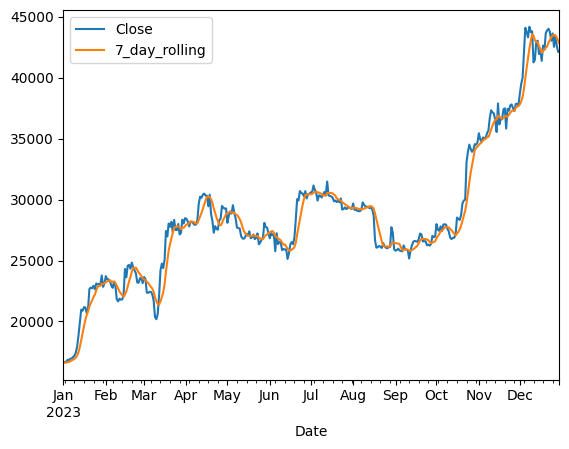

In [6]:
# explore 7-day rolling average
df["7_day_rolling"] = df["Close"].rolling(window=7).mean()
# see for 2023
df[["Close", "7_day_rolling"]].loc["2023"].plot()
plt.show()

Averages smooth out pikes on series.

In [7]:
# what's the month with the highest average
df.resample("ME").mean()["Close"].idxmax()

Timestamp('2021-11-30 00:00:00')

In [8]:
# now calculate daily returns
df["daily_returns"] = df["Close"].pct_change() * 100
# and get days with more than 10% change in closing price
df[abs(df["daily_returns"])>10].shape[0]

97

## Visualizations

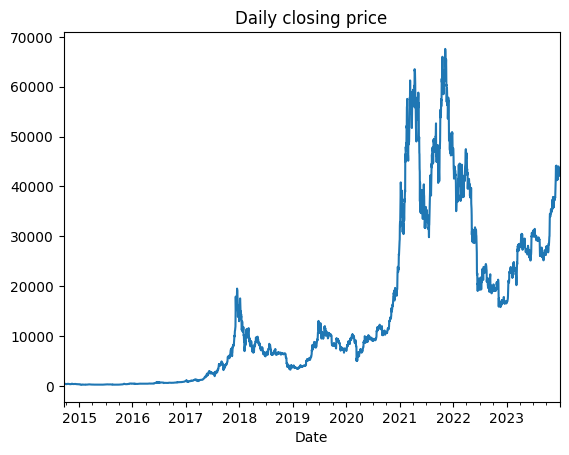

In [9]:
# example daily closing price
df["Close"].plot()
plt.title("Daily closing price")
plt.show()

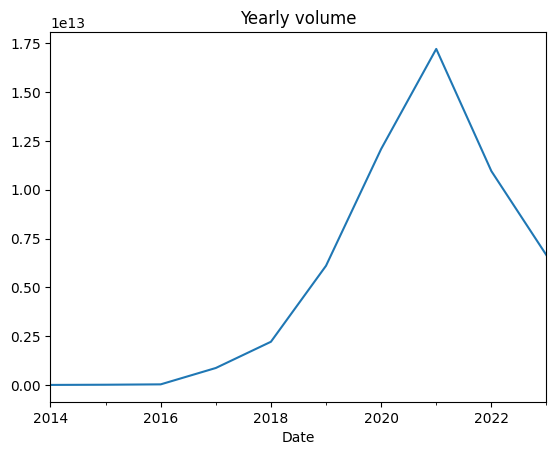

In [10]:
# see yearly volume
df.resample("YE").sum()["Volume"].plot()
plt.title("Yearly volume")
plt.show()

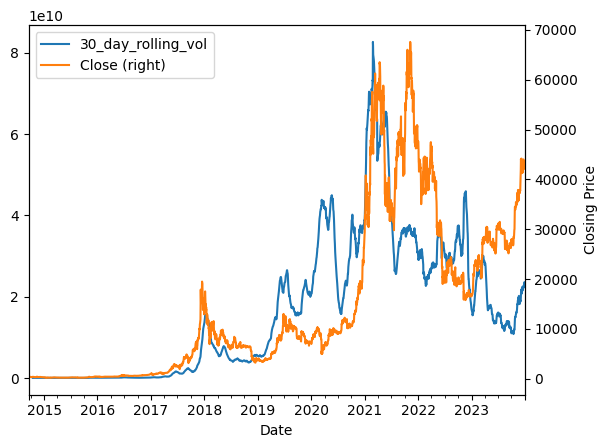

In [11]:
# see closing price and 30-day rolling volume
df["30_day_rolling_vol"] = df["Volume"].rolling(window=30).mean()
df["30_day_rolling_vol"].plot(legend=True)
ax = df["Close"].plot(secondary_y=True, legend=True)
ax.set_ylabel("Closing Price")
plt.show()

In [12]:
# see correlation between these two
df[["Close", "30_day_rolling_vol"]].corr()

,Close,30_day_rolling_vol
Close,1.000000,0.750445
30_day_rolling_vol,0.750445,1.000000


## Data Manipulation

In [13]:
# find null proportions
df.isnull().sum()

Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
7_day_rolling          6
daily_returns          1
30_day_rolling_vol    29
dtype: int64

In [14]:
# interpolate missing values on 7-day rolling
df["7_day_rolling"] = df["7_day_rolling"].interpolate()

In [15]:
# extract time variables
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["weekday"] = df.index.day_name()
df["weekday_num"] = df.index.weekday
df["is_weekend"] = df.index.weekday > 4

In [16]:
# feature lagged values
df["closed_lag1"] = df["Close"].shift(1)
df["closed_lag2"] = df["Close"].shift(2)

## Seasonal decomposition
1. **Trend:** direction of the time series
2. **Seasonality:** seasonal cycles on the time series.
    * **Additive:** are constant in value.
    * **Multiplicative:** seasonal cycles are proportional to the trend.
3. **Error term:** what is not explained by trend and seasonality (random walk)

**How to identify seasonality?** fit two models handling each model with each type and see which one fits better.

In [18]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

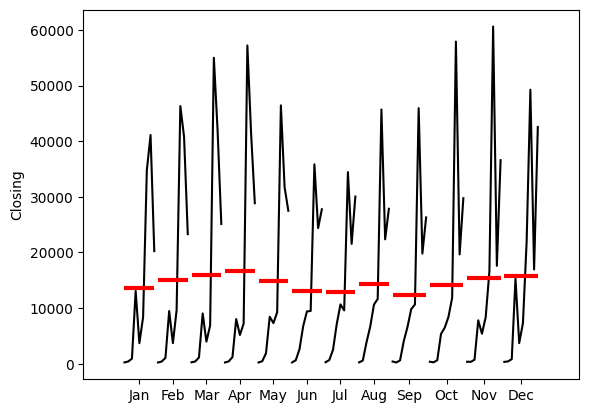

In [20]:
# plot monthly seasonality
month_plot(
    df["Close"].resample("ME").mean(),
    ylabel="Closing"
)

Red lines are average values through time. Seems not very seasonal, average has not great std.

Lines are month per all years.

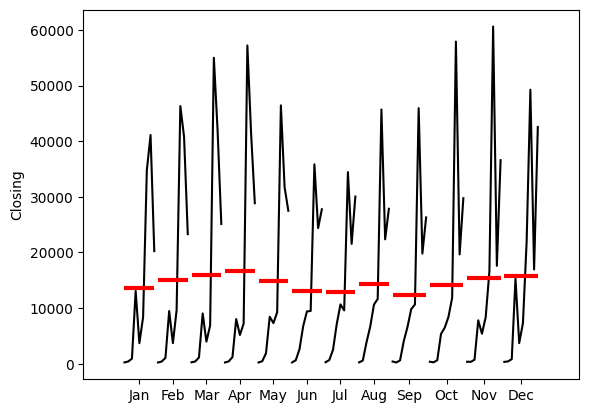

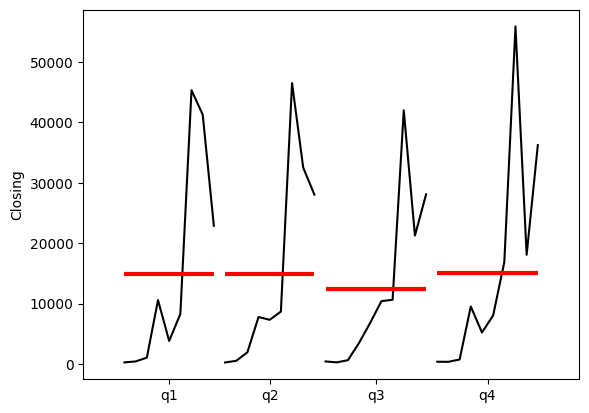

In [21]:
# plot quaterly seasonality
quarter_plot(
    df["Close"].resample("QE").mean(),
    ylabel="Closing"
)
plt.show()

Quarter helps out to find it out, confirms average with no great std.

In [24]:
# load new data to see seasonality in better way
df_choco = pd.read_csv(DATA_PATH / "choco_monthly_revenue.csv", index_col=0, parse_dates=True)

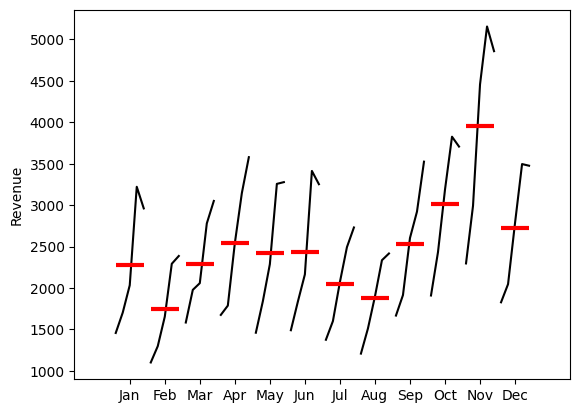

In [27]:
# plot quaterly seasonality
month_plot(
    df_choco["revenue"],
    ylabel="Revenue"
)
plt.show()

revenue seems more volatile depending on the month. So seasonality seems more evidence here.

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

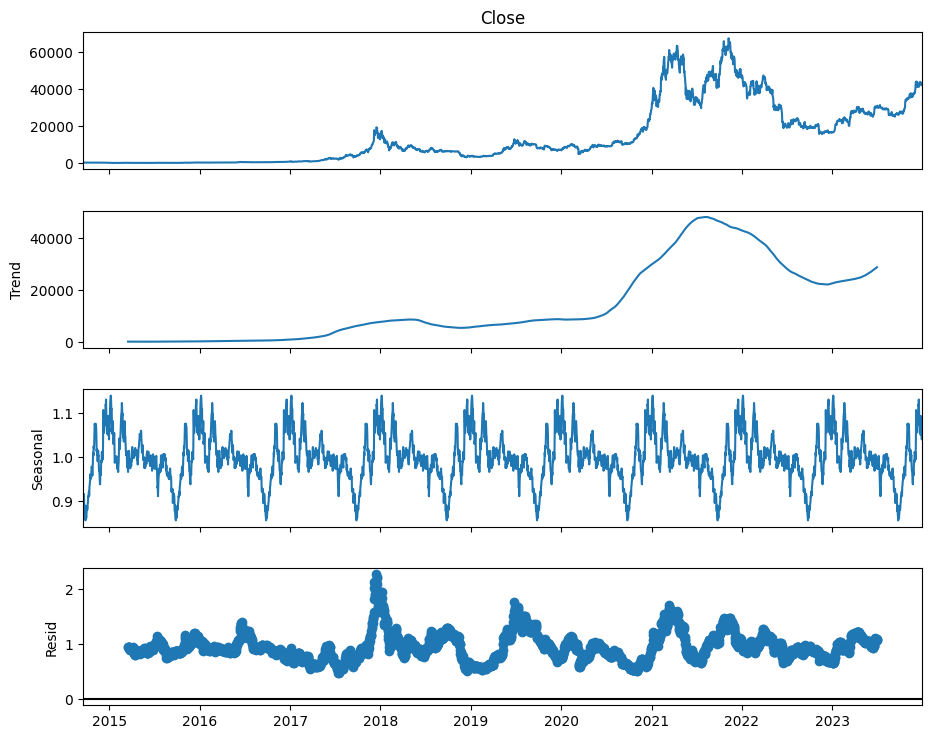

In [29]:
# seasonal decomposition plots
decomposition = seasonal_decompose(
    df["Close"], # this must contain 2 complete cycles
    model="multiplicative", # if season is not evident, with multiplicative could have more sense
    period=365 # for yearly
)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

`multiplicative` allows percentage comparison. Trend tends to be smooth when time periods are larger.

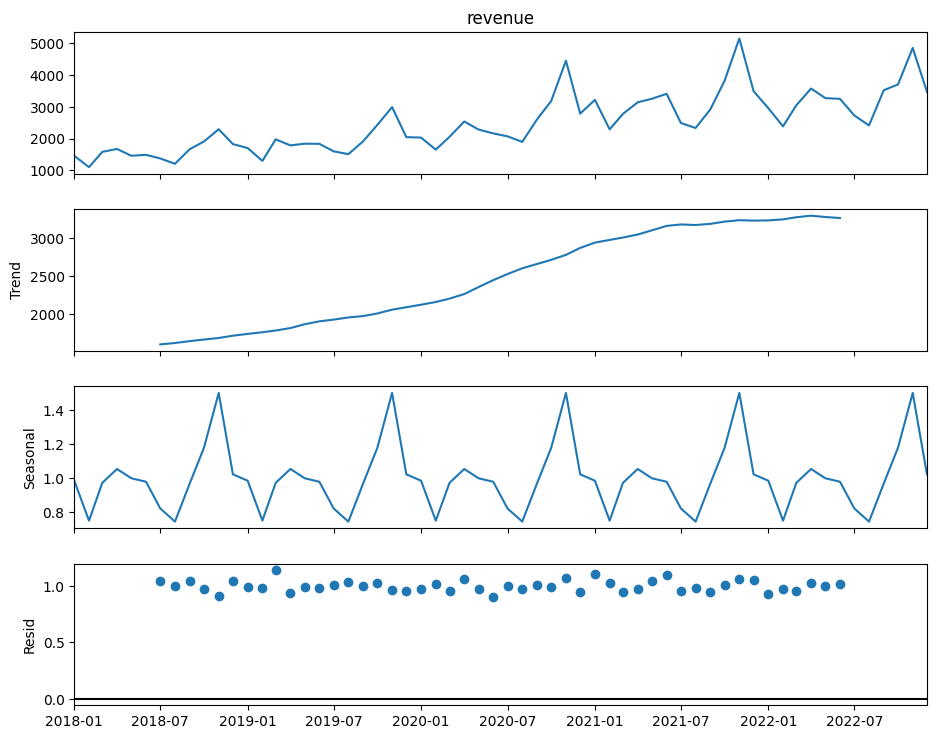

In [30]:
# seasonal decomposition plots
decomposition = seasonal_decompose(
    df_choco["revenue"], # this must contain 2 complete cycles
    model="multiplicative", # if season is not evident, with multiplicative could have more sense
    period=12 # for monthly
)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

## Auto-correlation
Tells if there is information in the past that helps to predict the future values. Uses lagged values for this purpose. So with this it can be seen how long in the past can a series go to see relevant information.

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

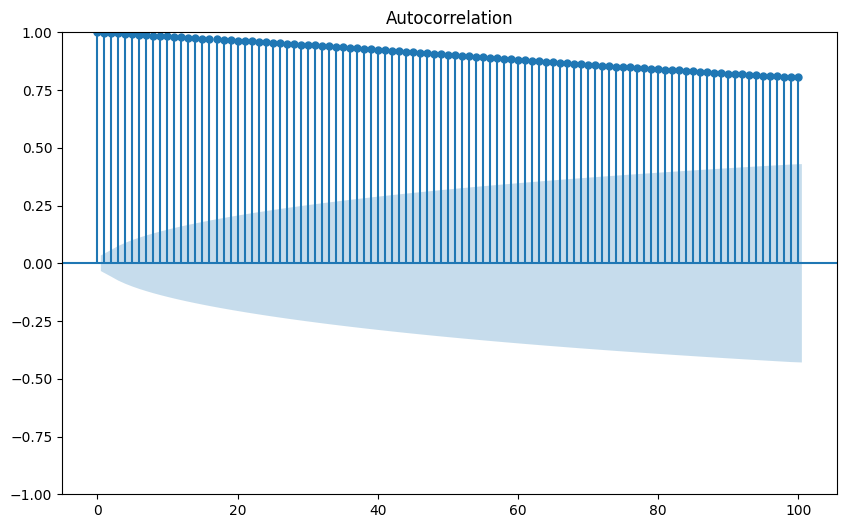

In [32]:
# plot the auto-correlation (acf)
_, ax = plt.subplots(figsize=(10, 6))
plot_acf(df["Close"], lags=100, ax=ax)
plt.show()

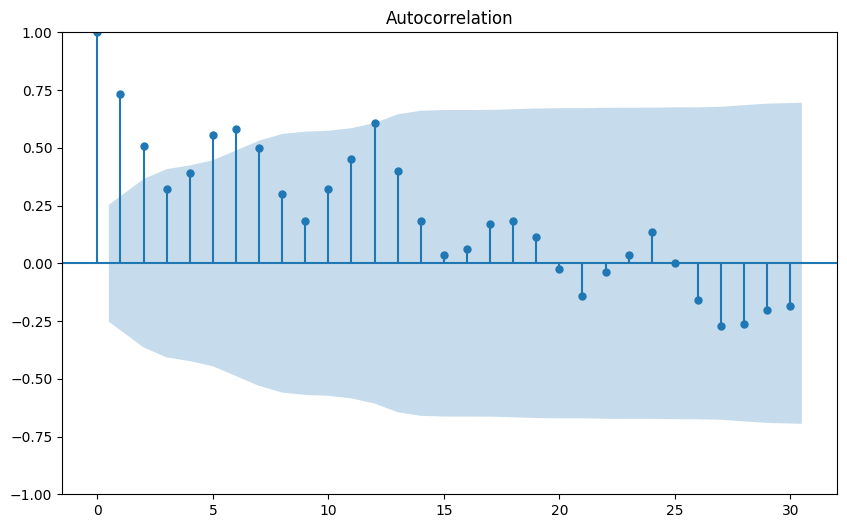

In [36]:
# plot the auto-correlation (acf)
_, ax = plt.subplots(figsize=(10, 6))
plot_acf(df_choco["revenue"], lags=30, ax=ax)
plt.show()

## Partial auto-correlation
Here relation could be seen without values between periods. This zooms in on the direct relations.

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf

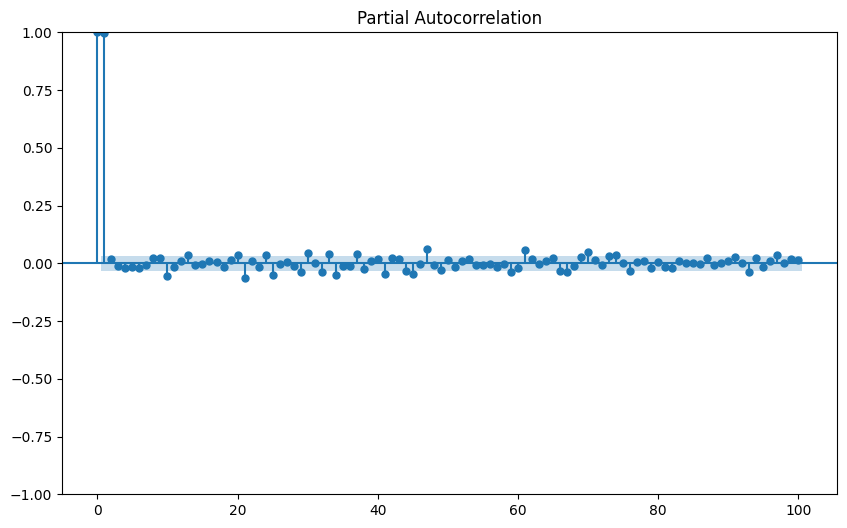

In [38]:
# plot the auto-correlation (pacf)
_, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df["Close"], lags=100, ax=ax)
plt.show()

This is more reliable to reality, cause recent relations are directly relevant to the present values

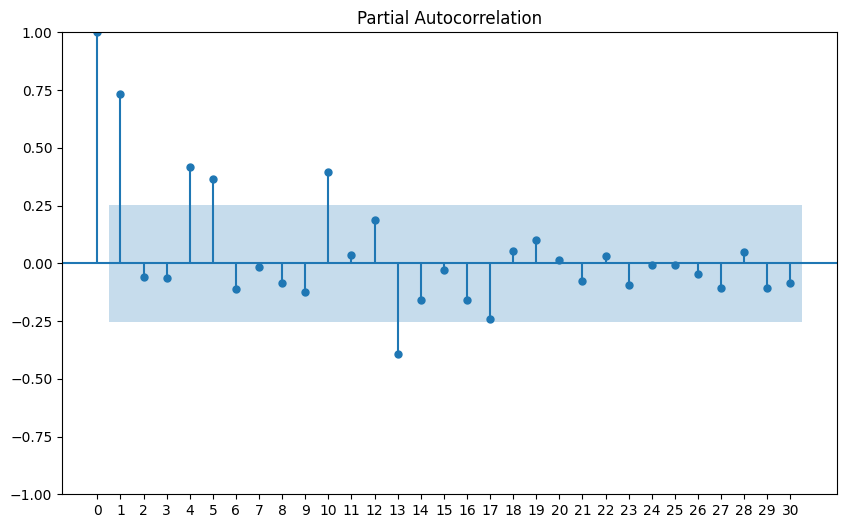

In [41]:
# plot the auto-correlation (pacf)
_, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df_choco["revenue"], lags=30, ax=ax)
plt.xticks(list(range(0, 31)))
plt.show()

Maybe some of that information from the auto-correlation is really the usefull one, looking at this plot.